In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from ipywidgets import Output

import pyneuralnet as pn
import datamaker as dm

## Dataset 2

(2, 2000)
(1, 2000)


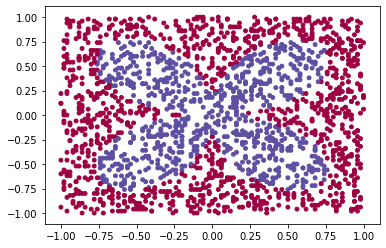

In [2]:
X, Y = pn.loadCSVData('./tests/clover.csv')
X, Y = X.T, Y.T
print(X.shape)
print(Y.shape)
plt.scatter(X[[0], :], X[[1], :], s=15,
            c=Y.astype('uint8'), cmap='Spectral')
plt.show()

In [3]:
np.random.seed(2)
num_iterations = 1000
learning_rate = 0.4
layout = ((10, 'elu'),
          (10, 'elu'),
          (1, 'sigmoid'),
         ) 

network = pn.buildNetwork(layout, X.shape[0], cost='logistic', reg='lasso')

Cost Function:  logistic
Regularization: lasso
Layer 0 : (10, 'elu') He-uniform
Layer 1 : (10, 'elu') He-uniform
Layer 2 : (1, 'sigmoid') Xavier-normal


In [4]:
network[0].initWeights('He-uniform')
network[1].initWeights('He-uniform')
network[2].initWeights('LeCun-uniform')
network.info()

Cost Function:  logistic
Regularization: lasso
Layer 0 : (10, 'elu') He-uniform
Layer 1 : (10, 'elu') He-uniform
Layer 2 : (1, 'sigmoid') LeCun-uniform


Progress: [####################] 100.0%

Iteration: 1000


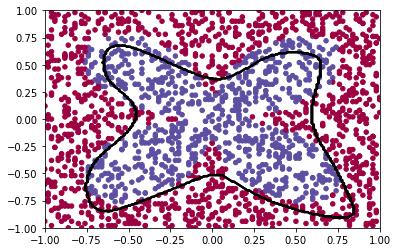

Accuracy: 86.4 %
Precision: 82.69999999999999 %
Recall: 84.1 %


In [5]:
newtork, costs, accs = network.gradientDescent(X, Y, num_iterations, learning_rate,
                        costfunction='logistic', showprogress=True,
                        recording=True, debugmsg='')


print('Iteration:', num_iterations)
pn.plot2DBoundary(X, Y, network, lines=True, fill=False, marksize=20)
H = network.predict(X)
acc, prec, rec = pn.evaluateModel(H, Y)
print('Accuracy:', acc[0,0]*100, '%')
print('Precision:', prec[0,0]*100, '%')
print('Recall:', rec[0,0]*100, '%')

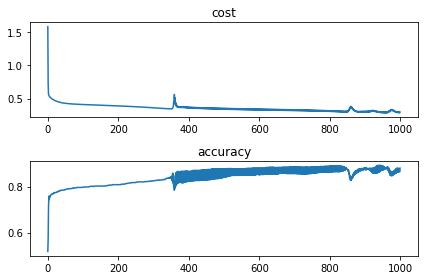

In [6]:
plt.subplot(211)
plt.plot(costs, label='cost')
plt.title('cost')

plt.subplot(212)
plt.plot(accs, label='accuracy')
plt.title('accuracy')

plt.tight_layout()
plt.show()

In [14]:
network[0].initWeights('LeCun-normal')
network[1].initWeights('LeCun-normal')
network[2].initWeights('LeCun-normal')
network.info()

Cost Function:  logistic
Regularization: lasso
Layer 0 : (10, 'tanh') LeCun-normal
Layer 1 : (10, 'tanh') LeCun-normal
Layer 2 : (1, 'sigmoid') LeCun-normal


Progress: [####################] 100.0%

Iteration: 10000


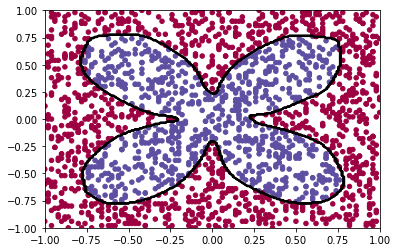

Accuracy: 99.6 %
Precision: 98.9 %
Recall: 100.0 %


In [15]:
np.random.seed(2)

newtork, costs, accs = network.gradientDescent(X, Y, num_iterations, learning_rate,
                        costfunction='logistic', showprogress=True,
                        recording=True, debugmsg='')


print('Iteration:', num_iterations)
pn.plot2DBoundary(X, Y, network, lines=True, fill=False, marksize=20)
H = network.predict(X)
acc, prec, rec = pn.evaluateModel(H, Y)
print('Accuracy:', acc[0,0]*100, '%')
print('Precision:', prec[0,0]*100, '%')
print('Recall:', rec[0,0]*100, '%')

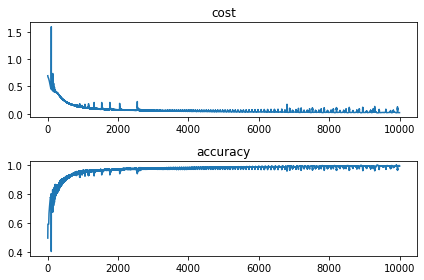

In [16]:
plt.subplot(211)
plt.plot(costs, label='cost')
plt.title('cost')

plt.subplot(212)
plt.plot(accs, label='accuracy')
plt.title('accuracy')

plt.tight_layout()
plt.show()

## Dataset 1

In [23]:
X, Y = dm.load_planar_dataset()
print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


Progress: [####################] 100.0%

Iteration: 10000


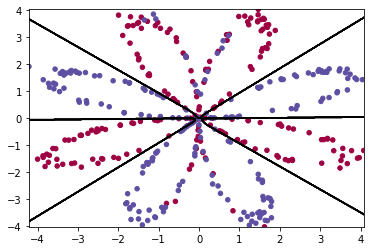

Accuracy: 90.5 %
Precision: 88.9 %
Recall: 92.5 %


In [25]:
np.random.seed(2)

num_iterations = 10000
learning_rate = 1.2
layout = ((4, 'tanh'),
          (1, 'sigmoid'),
         ) 

network = pn.buildNetwork(layout, X.shape[0])
newtork, costs, accs = network.gradientDescent(X, Y, num_iterations, learning_rate,
                        showprogress=True, debugmsg='', recording=True)


print('Iteration:', num_iterations)
pn.plot2DBoundary(X, Y, network, lines=True, fill=False, marksize=20)
H = network.predict(X)
acc, prec, rec = pn.evaluateModel(H, Y)
print('Accuracy:', acc[0,0]*100, '%')
print('Precision:', prec[0,0]*100, '%')
print('Recall:', rec[0,0]*100, '%')

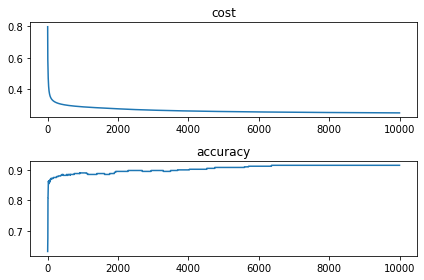

In [10]:
plt.subplot(211)
plt.plot(costs, label='cost')
plt.title('cost')

plt.subplot(212)
plt.plot(accs, label='accuracy')
plt.title('accuracy')

plt.tight_layout()
plt.show()

## Gradient Checking Tool


In [ ]:
def function(H, Y):
    m = H.shape[1]
    return -1 / m * (Y @ np.log(H.T) + (1 - Y) @ np.log(1 - H.T))

def gradient(H, Y):
    m = H.shape[1]
    return 1 / m * np.sum(np.divide(-Y, H) + np.divide(1 - Y, 1 - H), keepdims=True)

def function2(H, Y):
    m = H.shape[1]
    return -1 / m * np.sum(np.multiply(np.log(H), Y) + np.multiply((1 - Y), np.log(1 - H)), keepdims=True)

def gradient2(H, Y):
    m = H.shape[1]
    return 1 / m * np.sum(np.divide((H - Y), H * (1 - H)), keepdims=True) 

np.random.seed(20)
Z = np.random.rand(1, 3)
print('Input\n', Z, '\n')

Y = np.array([[0, 1, 1]])
print('Correct Answer\n', Y, '\n')

A = function(Z, Y)
print('Output\n', A, '\n')
A = function2(Z, Y)
print('Output 2\n', A, '\n')

dAdZ = gradient(Z, Y)
print('Gradient\n', dAdZ, '\n')

eps = 1e-5
plus = function(Z + eps, Y)
minus = function(Z - eps, Y)
dAdZ_check = (plus - minus) / (2 * eps)
print('Gradient Check\n', dAdZ_check)


dAdZ = gradient2(Z, Y)
print('\nGradient 2\n', dAdZ, '\n')

eps = 1e-5
plus = function2(Z + eps, Y)
minus = function2(Z - eps, Y)
dAdZ_check = (plus - minus) / (2 * eps)
print('Gradient 2 Check\n', dAdZ_check)

## Make fake data

In [77]:
def makeFakeData_AnonymousBoundary(f, a, b, r, func=lambda x1, x2, a, b: a*x1 + b*x2):
    '''
    DESCRIPTION:
    Creates a dataset with an elliptical decision boundary along.

    PARAMETERS:
    f -- (str) Filename.
    a -- (float) Vertical axis.
    b -- (float) Horizontal axis.

    RETURNS:
    None
    '''
    a = a
    b = b
    with open(f, 'w') as csvFile:
        writer = csv.writer(csvFile)
        for i in range(50):
            for j in range(40):
                x1 = round(float(np.random.rand(1)), 2)*2 - 1
                x2 = round(float(np.random.rand(1)), 2)*2 - 1
                y = 1*(func(x1, x2, a, b) <= r)
                inp = [x1, x2, y]
#                 print(inp)
                writer.writerow(inp)

    csvFile.close()

In [78]:
import csv

f = 'tests/clover.csv'

makeFakeData_AnonymousBoundary(f, 4, 1e-4, 1, lambda x1, x2, a, b: (x1**2 + x2**2)**3 / (a * x1**2 * x2**2 + b))

## Function testing

In [2]:
a = np.array([[1, 2, 0, 4, 1, 0, 3, 3, 2]])
print(a.astype(int))

[[1 2 0 4 1 0 3 3 2]]


In [3]:
b = pn.oneHot(5, a)
print(b)

[[0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [6]:
np.sum(b)

9.0